In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ARTHI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ARTHI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv(r"C:\Users\ARTHI\Downloads\cleaned_data.csv")
df.head()

,Text,Fake,Hate,Target,Severity
0,USER Abhi tak 2000 ke note me mujhe GPS nano c...,0,0,0,0
1,USER USER Abe katiye tumse kuch huaa toh jata ...,1,1,2,3
2,USER Ye sab sazish hai bina saman ke koi kaise...,1,1,2,2
3,abe jao tum to dasko pahle hi fash gye the jab...,1,0,1,1
4,Ab ye afbah kaun faila Raha hai ki Shahhen bag...,0,0,0,0


In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_text(text):
    text = re.sub(r'@\w+', '', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = text.lower() 
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

In [6]:
df['Text'] = df['Text'].fillna('').astype(str)  
df['Text'] = df['Text'].apply(preprocess_text)


In [7]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, min_df=3, max_df=0.9, stop_words='english')
X_vectorized = vectorizer.fit_transform(df['Text'])


In [8]:
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X_vectorized, df['Target'])


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [10]:
nb = MultinomialNB()
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_nb = grid_search.best_estimator_
best_nb.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [11]:
y_pred = best_nb.predict(X_test)
print("Best Alpha:", grid_search.best_params_['alpha'])
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best Alpha: 0.1
Accuracy: 0.7412854030501089

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.51      0.60       471
           1       0.73      0.84      0.78       451
           2       0.72      0.73      0.72       465
           3       0.78      0.90      0.83       449

    accuracy                           0.74      1836
   macro avg       0.74      0.74      0.74      1836
weighted avg       0.74      0.74      0.73      1836


Confusion Matrix:
 [[240  76  82  73]
 [ 30 380  19  22]
 [ 55  53 339  18]
 [  4  12  31 402]]


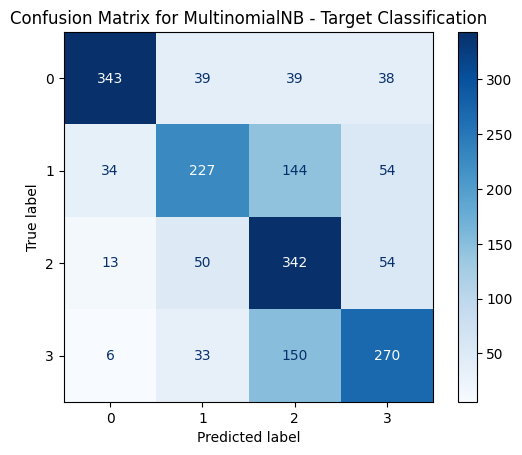

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_target = best_nb.predict(X_test)

cm_target = confusion_matrix(y_test, y_pred_target)

disp_target = ConfusionMatrixDisplay(confusion_matrix=cm_target, display_labels=best_nb.classes_)
disp_target.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for MultinomialNB - Target Classification')
plt.show()


In [ ]:
feature_names = vectorizer.get_feature_names_out()
sorted_idx = X_vectorized.sum(axis=0).argsort()[0, ::-1]
top_features = [feature_names[i] for i in sorted_idx[:50]]


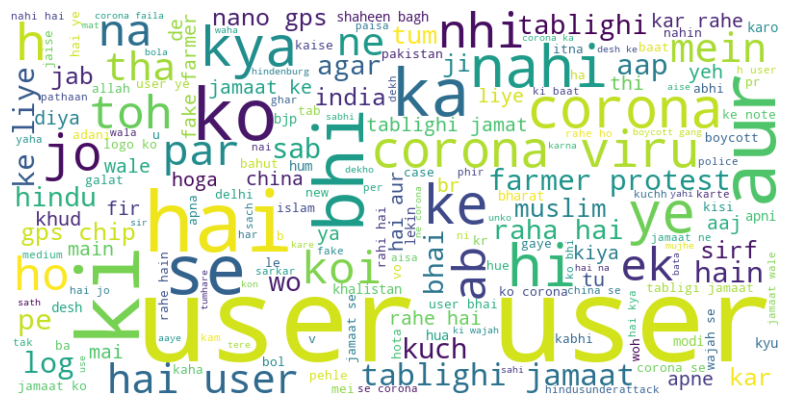

In [ ]:
text_for_wordcloud = ' '.join(df['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

In [40]:
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X_vectorized, df['Severity'])

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

In [46]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("\nLogistic Regression Accuracy for Severity:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report for Severity:\n", classification_report(y_test, y_pred_lr))
print("\nConfusion Matrix for Severity:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression Accuracy for Severity: 0.7118736383442266

Classification Report for Severity:
               precision    recall  f1-score   support

           0       0.68      0.67      0.67       459
           1       0.59      0.50      0.54       459
           2       0.70      0.75      0.73       459
           3       0.85      0.92      0.88       459

    accuracy                           0.71      1836
   macro avg       0.70      0.71      0.71      1836
weighted avg       0.70      0.71      0.71      1836


Confusion Matrix for Severity:
 [[308  96  34  21]
 [ 95 230  97  37]
 [ 41  55 345  18]
 [ 11  10  14 424]]


In [49]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [50]:
from sklearn.metrics import accuracy_score
ensemble_pred = (y_pred_svm + y_pred_rf) // 2 

print("\nEnsemble Model Accuracy:", accuracy_score(y_test, ensemble_pred))
print("\nClassification Report for Ensemble Model:\n", classification_report(y_test, ensemble_pred))
print("\nConfusion Matrix for Ensemble Model:\n", confusion_matrix(y_test, ensemble_pred))



Ensemble Model Accuracy: 0.7418300653594772

Classification Report for Ensemble Model:
               precision    recall  f1-score   support

           0       0.67      0.78      0.72       459
           1       0.59      0.49      0.54       459
           2       0.73      0.76      0.75       459
           3       0.97      0.93      0.95       459

    accuracy                           0.74      1836
   macro avg       0.74      0.74      0.74      1836
weighted avg       0.74      0.74      0.74      1836


Confusion Matrix for Ensemble Model:
 [[358  69  27   5]
 [139 226  87   7]
 [ 28  79 349   3]
 [  8   8  14 429]]


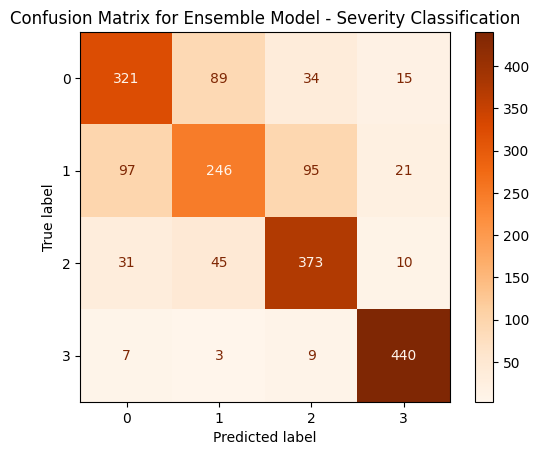

In [53]:

y_pred_severity = ensemble_model.predict(X_test)


cm_severity = confusion_matrix(y_test, y_pred_severity)

disp_severity = ConfusionMatrixDisplay(confusion_matrix=cm_severity, display_labels=ensemble_model.classes_)
disp_severity.plot(cmap='Oranges', values_format='d')
plt.title('Confusion Matrix for Ensemble Model - Severity Classification')
plt.show()


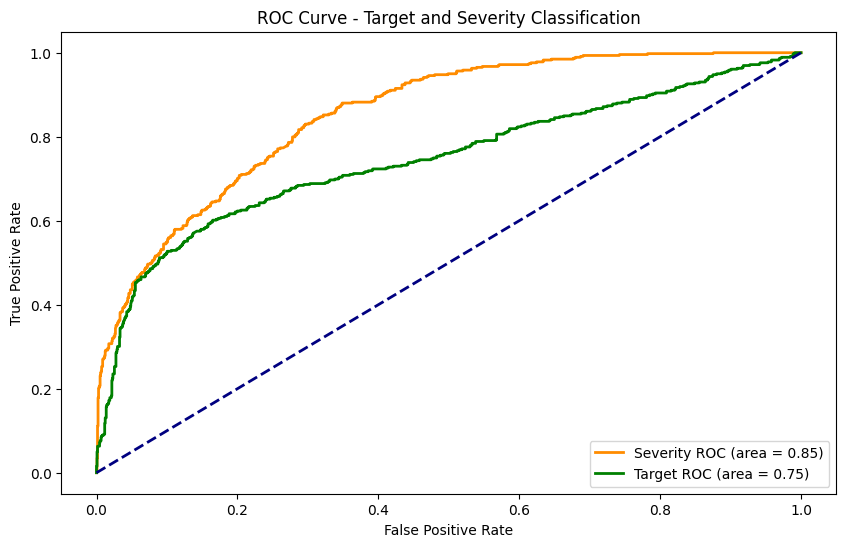

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob_severity = ensemble_model.predict_proba(X_test)[:, 1]  
fpr_sev, tpr_sev, _ = roc_curve(y_test, y_prob_severity, pos_label=1)
roc_auc_sev = auc(fpr_sev, tpr_sev)

y_prob_target = best_nb.predict_proba(X_test)[:, 1]  
fpr_tar, tpr_tar, _ = roc_curve(y_test, y_prob_target, pos_label=1)
roc_auc_tar = auc(fpr_tar, tpr_tar)

plt.figure(figsize=(10, 6))

plt.plot(fpr_sev, tpr_sev, color='darkorange', lw=2, label=f'Severity ROC (area = {roc_auc_sev:.2f})')

plt.plot(fpr_tar, tpr_tar, color='green', lw=2, label=f'Target ROC (area = {roc_auc_tar:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot details
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Target and Severity Classification')
plt.legend(loc='lower right')
plt.show()


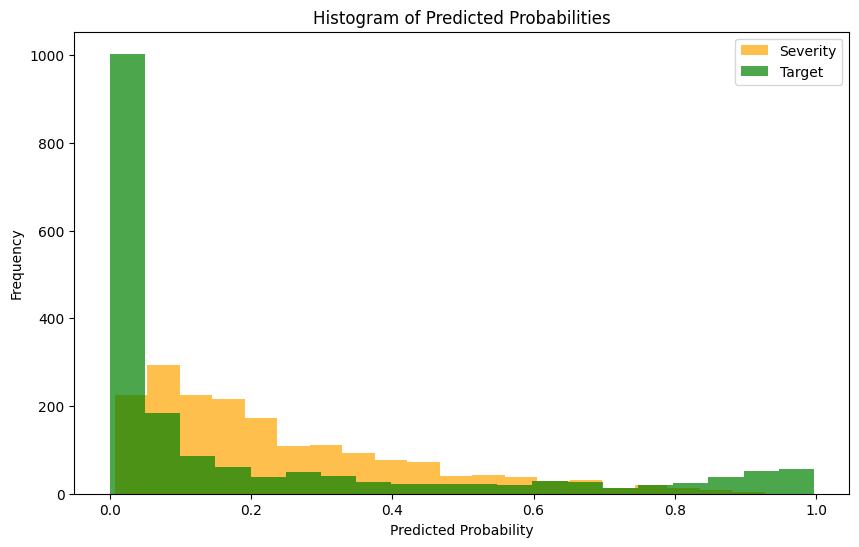

In [57]:
plt.figure(figsize=(10, 6))
plt.hist(y_prob_severity, bins=20, alpha=0.7, label='Severity', color='orange')
plt.hist(y_prob_target, bins=20, alpha=0.7, label='Target', color='green')

# Plot details
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()
